In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from itertools import combinations
from matplotlib import pyplot as plt
from utils import *

In [3]:
from matplotlib import rcParams, cm
plt.style.use('seaborn')

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

rcParams['axes.titlesize'] = 15
rcParams['axes.labelsize'] = 15
rcParams['figure.titlesize'] = 15

In [4]:
trainW = WordCounter(get_tokenized_sentences('data/trainW_token_end.txt'))
trainT = WordCounter(get_tokenized_sentences('data/trainT_token_end.txt'))
test1 = WordCounter(get_tokenized_sentences('data/test1_token_end.txt'))
test2 = WordCounter(get_tokenized_sentences('data/test2_token_end.txt'))
train_easy = WordCounter(get_tokenized_sentences('data/train_easy_token_end.txt'))
test_easy = WordCounter(get_tokenized_sentences('data/test_easy_token_end.txt'))
train_debug = WordCounter(get_tokenized_sentences('data/train_debug_token_end.txt'))
test_debug = WordCounter(get_tokenized_sentences('data/test_debug_token_end.txt'))

# ngram model

### Unigram model

In [5]:
unigram_model_trainW = UnigramModel(trainW, k=1)

for text in [trainW, trainT, test1, test2]:
    print(unigram_model_trainW.calculate_avg_ll(text))

-18.497573151470494
-18.555918913789192
-18.547618544163544
-18.54868310979827


In [6]:
unigram_model_trainW = UnigramModel(trainW, k=1)
unigram_model_trainW.calculate_avg_ll(trainT)

-18.555918913789192

In [7]:
unigram_model_trainT = UnigramModel(trainT, k=1)

for text in [trainW, trainT, test1, test2]:
    print(unigram_model_trainT.calculate_avg_ll(text))

-18.4748498669285
-9.32131744722474
-9.561877655497758
-10.221724078549878


### Bigram model

In [8]:
bigram_trainT = MultigramModel(trainT, n=2, k=0.001)
trigram_trainT = MultigramModel(trainT, n=3, k=0.001)

In [56]:
bigram_easy = MultigramModel(train_debug, n=2, k=0)

In [57]:
bigram_easy.calculate_avg_ll(train_debug)

-0.5454545454545454

In [12]:
bigram_easy.test_startinfos

{('i',): {'log': 0.0, 'count': 3}}

In [13]:
bigram_easy.test_condinfos

{('i', 'have'): {'log': 0.0, 'count': 3},
 ('have', 'a'): {'log': 0.0, 'count': 3},
 ('a', 'cat'): {'log': -1.0, 'count': 2},
 ('cat', '<END>'): {'log': -1.0, 'count': 1},
 ('a', 'dog'): {'log': -1.0, 'count': 2},
 ('dog', '<END>'): {'log': 0.0, 'count': 2},
 ('cat', 'and'): {'log': -1.0, 'count': 1},
 ('and', 'a'): {'log': 0.0, 'count': 1}}

In [14]:
def plot_models(train, test, train_label, test_label, ks=None, plot_k0=False):
    fig, ax = plt.subplots()
    if ks is None:
        ks = [10**power for power in range(-4, 6, 2)]
    if plot_k0:
        ks = [0] + ks
    for k in ks:
        ns = range(1, 6)
        avg_lls_at_k = []
        unigram_model = UnigramModel(train, k=k)
        avg_lls_at_k.append(unigram_model.calculate_avg_ll(test))
        for n in ns[1:]:
            multigram_model = MultigramModel(train, n=n, k=k)
            avg_lls_at_k.append(multigram_model.calculate_avg_ll(test))

        ax.plot(ns, avg_lls_at_k, label=k)
    ax.set_xticks(range(1, 6))
    ax.set_xlabel('ngram')
    ax.set_ylabel('Average log likelihood (test set)')
    ax.legend(title='k', bbox_to_anchor=(1.04, 0), loc='lower left')
    ax.set_title(f'{train_label} -> {test_label}')
    fig.savefig(f'viz/{train_label}_to_{test_label}.png', bbox_inches='tight')

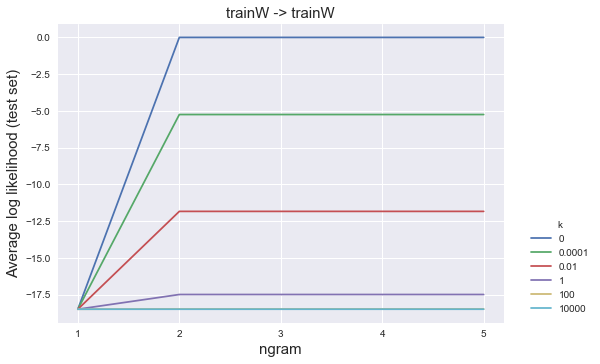

In [15]:
plot_models(trainW, trainW, 'trainW', 'trainW', plot_k0=True)

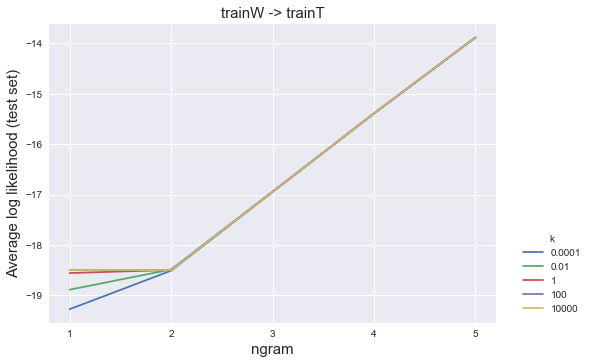

In [16]:
plot_models(trainW, trainT, 'trainW', 'trainT')

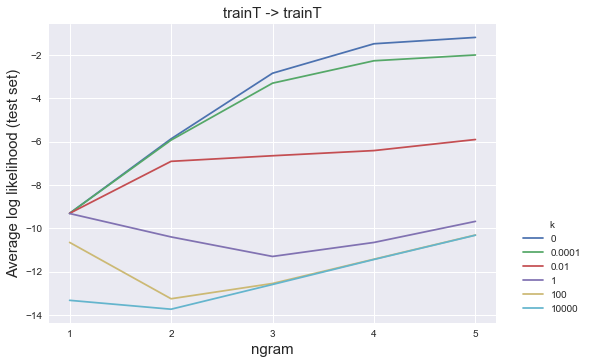

In [17]:
plot_models(trainT, trainT, 'trainT', 'trainT', plot_k0=True)

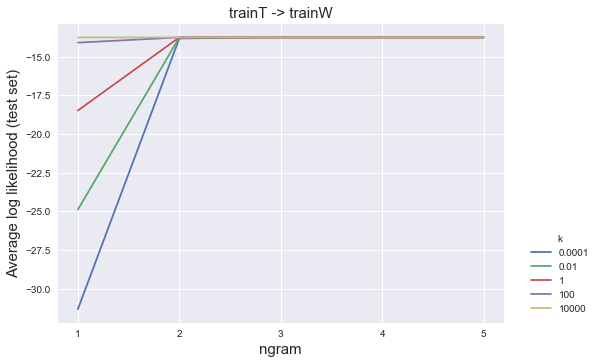

In [18]:
plot_models(trainT, trainW, 'trainT', 'trainW')

# Interpolation

In [25]:
class CondProb:
    def __init__(self, train):
        self.start_condprobs = {}
        self.general_condprobs = {}
        self.uniform_prob = 1 / (len(train.all_ngram_counts[1]) + 1)

        for unigram, unigram_count in train.all_ngram_counts[1].items():
            if unigram_count['start']:
                self.start_condprobs[unigram] = unigram_count['start'] / train.sentence_count
            self.general_condprobs[unigram] = unigram_count['all'] / train.token_count

        for n in range(2, 6):
            start_prevgram_cumprobs = {}
            general_prevgram_cumprobs = {}
            for ngram, ngram_count in train.all_ngram_counts[n].items():
                prevgram = ngram[:-1]
                if ngram_count['start']:
                    start_condprob = ngram_count['start'] / train.all_ngram_counts[n - 1][prevgram]['start']
                    self.start_condprobs[ngram] = start_condprob
                    start_prevgram_cumprobs[prevgram] = start_prevgram_cumprobs.get(prevgram, 0) + start_condprob

                general_condprob = ngram_count['all'] / train.all_ngram_counts[n - 1][prevgram]['all']
                self.general_condprobs[ngram] = general_condprob
                general_prevgram_cumprobs[prevgram] = general_prevgram_cumprobs.get(prevgram, 0) + general_condprob

            for prevgram, cumprob in start_prevgram_cumprobs.items():
                assert isclose(cumprob, 1, rel_tol=1e-5)
            for prevgram, cumprob in general_prevgram_cumprobs.items():
                assert isclose(cumprob, 1, rel_tol=1e-5)

    def get_test_condprobs(self, test_file):
        test_token_count = sum(len(sentence) for sentence in get_tokenized_sentences(test_file))
        test_condprobs = np.zeros((test_token_count, 6))
        test_condprobs[:, 0] = self.uniform_prob

        row = 0
        for sentence in get_tokenized_sentences(test_file):
            for i, token in enumerate(sentence):
                for n in range(1, 6):
                    ngram_start = i + 1 - n
                    ngram_end = i + 1
                    if ngram_start >= 0:
                        ngram = tuple(sentence[ngram_start:ngram_end])
                        test_condprobs[row, n] = self.general_condprobs.get(ngram, 0)
                    else:
                        start_ngram = tuple(sentence[0:ngram_end])
                        test_condprobs[row, n] = self.start_condprobs.get(start_ngram, 0)

                row += 1

        return test_condprobs

In [26]:
condprob_modelW = CondProb(trainW)
test_condprobsWW = condprob_modelW.get_test_condprobs('data/trainW_token_end.txt')
test_condprobsWT = condprob_modelW.get_test_condprobs('data/trainT_token_end.txt')

In [27]:
condprob_modelT = CondProb(trainT)
test_condprobsTW = condprob_modelT.get_test_condprobs('data/trainW_token_end.txt')
test_condprobsTT = condprob_modelT.get_test_condprobs('data/trainT_token_end.txt')
test_condprobsT1 = condprob_modelT.get_test_condprobs('data/test1_token_end.txt')
test_condprobsT2 = condprob_modelT.get_test_condprobs('data/test2_token_end.txt')

In [28]:
def calculate_avg_ll(test_condprobs, cols, weights=None):
    if weights is None:
        weights = np.ones(len(cols)) / len(cols)
    assert isclose(sum(weights), 1, rel_tol=1e-5)
    return np.log2((test_condprobs[:, cols] * np.array(weights)).sum(axis=1)).mean()

In [76]:
def plot_interpolate_with_uniform(ax, test_condprobs, ngram_weights, legend=False, ylim=(-20, 0), cmap=cm.winter_r, plot_text=True):
    ns = list(range(1, 6))

    for i, ngram_weight in enumerate(ngram_weights[::-1]):
        avg_lls = []
        for n in ns:
            avg_ll = calculate_avg_ll(test_condprobs, [0, n], weights=[1-ngram_weight, ngram_weight])
            avg_lls.append(avg_ll)

        ax.plot(ns, avg_lls, 'o-', label=f'{ngram_weight:.2f}', color=cmap(ngram_weight))
        if plot_text and (i == 0 or i == len(ngram_weights) - 1):
            ax.text(n+0.1, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=15, va='center', color=cmap(ngram_weight))
    if legend:
        ax.legend(title='Fraction of\nngram model', bbox_to_anchor=(1.04, 0), loc='lower left', **legend_opts)
        
    ax.set_xticks(range(1, 6))
    ax.set_yticks(np.arange(ylim[0], ylim[1]+1, 5))
    ax.set_xlim(0, 6)
    ax.set_ylim(ylim)
    
    ax.set_xlabel('ngram')
    ax.set_ylabel('Average log likelihood')

In [87]:
(test_condprobsT1 == 0).sum(axis=0)

array([     0,  11279, 113861, 246254, 299264, 310940])

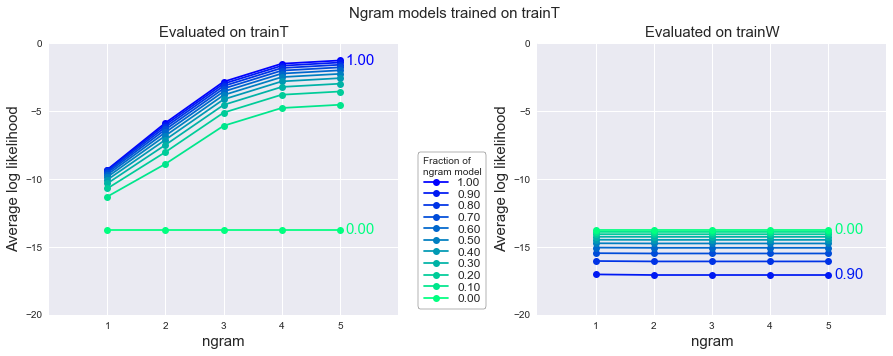

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Ngram models trained on trainT')
plt.subplots_adjust(wspace=0.4)

plot_interpolate_with_uniform(ax[0], test_condprobsTT, np.arange(0, 1.01, 0.1), legend=True)
plot_interpolate_with_uniform(ax[1], test_condprobsTW, np.arange(0, 0.95, 0.1))
ax[0].set_title('Evaluated on trainT')
ax[1].set_title('Evaluated on trainW')
fig.savefig('viz/ngram_TT_TW.png')

plt.show()

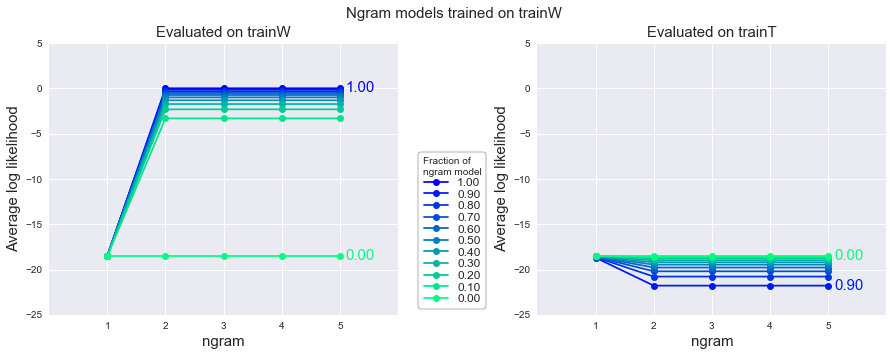

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Ngram models trained on trainW')
plt.subplots_adjust(wspace=0.4)

plot_interpolate_with_uniform(ax[0], test_condprobsWW, np.arange(0, 1.01, 0.1), ylim=(-25, 5), legend=True)
plot_interpolate_with_uniform(ax[1], test_condprobsWT, np.arange(0, 0.95, 0.1), ylim=(-25, 5))
ax[0].set_title('Evaluated on trainW')
ax[1].set_title('Evaluated on trainT')
fig.savefig('viz/ngram_WW_WT.png')

plt.show()

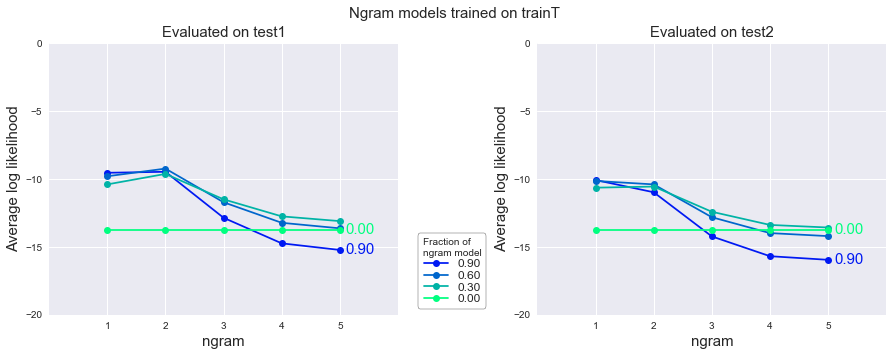

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Ngram models trained on trainT')
plt.subplots_adjust(wspace=0.4)

plot_interpolate_with_uniform(ax[0], test_condprobsT1, np.arange(0, 0.95, 0.3), legend=True)
plot_interpolate_with_uniform(ax[1], test_condprobsT2, np.arange(0, 0.95, 0.3))
ax[0].set_title('Evaluated on test1', fontsize=15)
ax[1].set_title('Evaluated on test2', fontsize=15)
fig.savefig('viz/ngram_T1_T2.png')

plt.show()

In [53]:
unigram_weights = np.arange(0, 1, 0.01)
full_unigram_weights = np.arange(0, 1.01, 0.01)
avg_lls_TT = [calculate_avg_ll(test_condprobsTT, [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in full_unigram_weights]
avg_lls_TW = [calculate_avg_ll(test_condprobsTW, [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]
avg_lls_T1 = [calculate_avg_ll(test_condprobsT1, [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]
avg_lls_T2 = [calculate_avg_ll(test_condprobsT2, [0, 1], weights=[1-unigram_weight, unigram_weight]) for unigram_weight in unigram_weights]

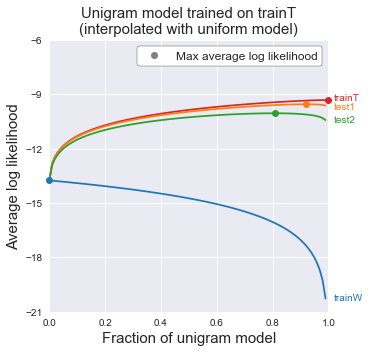

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(full_unigram_weights, avg_lls_TT, color='tab:red')
ax.plot(unigram_weights, avg_lls_TW, color='tab:blue')
ax.plot(unigram_weights, avg_lls_T1, color='tab:orange')
ax.plot(unigram_weights, avg_lls_T2, color='tab:green')

ax.text(1.02, avg_lls_TT[-1]+0.1, s='trainT', va='center', color='tab:red', fontsize=10)
ax.text(1.02, avg_lls_TW[-1], s='trainW', va='center', color='tab:blue', fontsize=10)
ax.text(1.02, avg_lls_T1[-1]-0.1, s='test1', va='center', color='tab:orange', fontsize=10)
ax.text(1.02, avg_lls_T2[-1], s='test2', va='center', color='tab:green', fontsize=10)

ax.set_xticks(np.arange(0, 1.1, 0.2))
ax.set_yticks(np.arange(-21, -5, 3))
ax.set_xlim(0, 1)
ax.set_ylim(-21, -6)

ax.plot(full_unigram_weights[np.argmax(avg_lls_TT)], max(avg_lls_TT), 'o', color='tab:red', clip_on=False)
ax.plot(unigram_weights[np.argmax(avg_lls_TW)], max(avg_lls_TW), 'o', color='tab:blue', clip_on=False)
ax.plot(unigram_weights[np.argmax(avg_lls_T1)], max(avg_lls_T1), 'o', color='tab:orange', clip_on=False)
ax.plot(unigram_weights[np.argmax(avg_lls_T2)], max(avg_lls_T2), 'o', color='tab:green', clip_on=False)
ax.plot(100, 100, 'o', color='tab:gray', label='Max average log likelihood')

ax.set_xlabel('Fraction of unigram model')
ax.set_ylabel('Average log likelihood')
ax.set_title('Unigram model trained on trainT\n(interpolated with uniform model)', fontsize=15)
ax.legend(**legend_opts)
plt.show()

In [89]:
cols = []
avg_lls_TT = []
avg_lls_TW = []
avg_lls_T1 = []
avg_lls_T2 = []
labels = []

ns = range(6)
label = ''
for n in ns:
    cols.append(n)
    label += f'{n}\n'
    labels.append(label)
    avg_lls_TT.append(calculate_avg_ll(test_condprobsTT, cols))
    avg_lls_TW.append(calculate_avg_ll(test_condprobsTW, cols))
    avg_lls_T1.append(calculate_avg_ll(test_condprobsT1, cols))
    avg_lls_T2.append(calculate_avg_ll(test_condprobsT2, cols))
    
labels[0] = '0\n(uniform)'

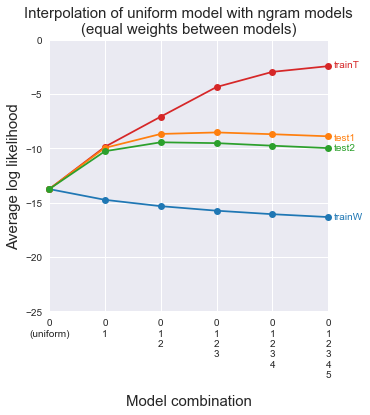

In [91]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(ns, avg_lls_TT, 'o-', color='tab:red', clip_on=False)
ax.plot(ns, avg_lls_TW, 'o-', color='tab:blue', clip_on=False)
ax.plot(ns, avg_lls_T1, 'o-', color='tab:orange', clip_on=False)
ax.plot(ns, avg_lls_T2, 'o-', color='tab:green', clip_on=False)

ax.text(5.1, avg_lls_TT[-1]+0.1, s='trainT', va='center', color='tab:red', fontsize=10)
ax.text(5.1, avg_lls_TW[-1], s='trainW', va='center', color='tab:blue', fontsize=10)
ax.text(5.1, avg_lls_T1[-1]-0.1, s='test1', va='center', color='tab:orange', fontsize=10)
ax.text(5.1, avg_lls_T2[-1], s='test2', va='center', color='tab:green', fontsize=10)

ax.set_xticks(np.arange(0, 6, 1))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(-25, 1, 5))
ax.set_xlim(0, 5)
ax.set_ylim(-25, 0)

ax.set_xlabel('Model combination')
ax.set_ylabel('Average log likelihood')
ax.set_title('Interpolation of uniform model with ngram models\n(equal weights between models)', fontsize=15)

fig.savefig('viz/combination.png', bbox_inches='tight')
plt.show()

In [64]:
col_combinations = []
for n_models in range(1, 6):
    for combination in combinations(range(1, 6), n_models):
        col_combinations.append((0,) + combination)

In [68]:
avg_lls_combinationsT1 = {}
avg_lls_combinationsT2 = {}
for col_combination in col_combinations:
    avg_lls_combinationsT1[col_combination] = calculate_avg_ll(test_condprobsT1, col_combination)
    avg_lls_combinationsT2[col_combination] = calculate_avg_ll(test_condprobsT2, col_combination)

In [72]:
sorted(avg_lls_combinationsT1.items(), key=lambda item: item[1], reverse=True)

[((0, 1, 2, 3), -8.539308549509785),
 ((0, 1, 2), -8.677635052241927),
 ((0, 1, 2, 3, 4), -8.703040322053795),
 ((0, 1, 2, 3, 5), -8.744606379627028),
 ((0, 1, 2, 4), -8.772009761920332),
 ((0, 1, 2, 5), -8.865261220371968),
 ((0, 1, 2, 3, 4, 5), -8.89426522575706),
 ((0, 1, 2, 4, 5), -8.995880142615233),
 ((0, 1, 3), -9.26239594407285),
 ((0, 2, 3), -9.266296868279374),
 ((0, 2), -9.312835284527162),
 ((0, 1, 3, 4), -9.471118421367697),
 ((0, 2, 3, 4), -9.509621139213172),
 ((0, 1, 3, 5), -9.520721768981877),
 ((0, 2, 4), -9.531523701515367),
 ((0, 2, 3, 5), -9.553168890776696),
 ((0, 2, 5), -9.634088964278938),
 ((0, 1, 3, 4, 5), -9.704403110118742),
 ((0, 2, 3, 4, 5), -9.753883004066234),
 ((0, 2, 4, 5), -9.837796344873123),
 ((0, 1, 4), -9.838540213471283),
 ((0, 1), -9.956816061027446),
 ((0, 1, 5), -10.01440522718131),
 ((0, 1, 4, 5), -10.119163382106215),
 ((0, 3), -11.59018060892278),
 ((0, 3, 4), -11.938570333234324),
 ((0, 3, 5), -11.991927803530515),
 ((0, 3, 4, 5), -12.2546

In [73]:
sorted(avg_lls_combinationsT2.items(), key=lambda item: item[1], reverse=True)

[((0, 1, 2), -9.445884532938882),
 ((0, 1, 2, 3), -9.523046005358427),
 ((0, 1, 2, 4), -9.699112749457216),
 ((0, 1, 2, 5), -9.745950997073361),
 ((0, 1, 2, 3, 4), -9.759201280748064),
 ((0, 1, 2, 3, 5), -9.78227142563446),
 ((0, 1, 2, 4, 5), -9.963945647277088),
 ((0, 1, 2, 3, 4, 5), -9.980591551091008),
 ((0, 1, 3), -10.052679049730347),
 ((0, 1), -10.265783597326585),
 ((0, 1, 3, 4), -10.350734909700508),
 ((0, 1, 3, 5), -10.378830451692922),
 ((0, 2), -10.398923493473273),
 ((0, 1, 4), -10.474712215622496),
 ((0, 1, 5), -10.565160592682265),
 ((0, 2, 3), -10.591041356662833),
 ((0, 1, 3, 4, 5), -10.619662462248176),
 ((0, 2, 4), -10.794168071717818),
 ((0, 1, 4, 5), -10.808053637717721),
 ((0, 2, 5), -10.84627816071672),
 ((0, 2, 3, 4), -10.911480174325899),
 ((0, 2, 3, 5), -10.93577439856811),
 ((0, 2, 4, 5), -11.144821513478647),
 ((0, 2, 3, 4, 5), -11.187788002503414),
 ((0, 3), -12.628932770046928),
 ((0, 3, 4), -13.076755594385082),
 ((0, 3, 5), -13.107134391097372),
 ((0, 3, 